mpi4py is not available. You must install it


Operator `initdamp` ran in 0.01 s


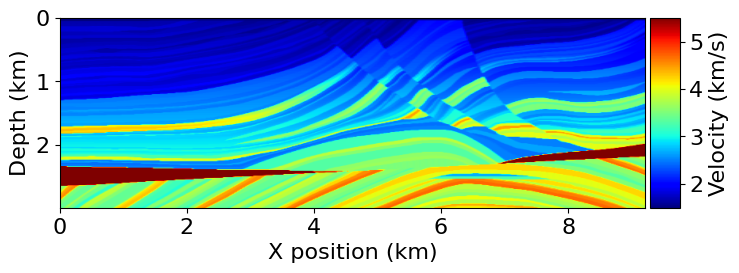

In [1]:
from devito import *
from examples.seismic import Model, AcquisitionGeometry, PointSource, RickerSource, TimeAxis
from examples.seismic import plot_velocity, plot_shotrecord, plot_perturbation, plot_image
from examples.seismic.acoustic import AcousticWaveSolver
from extra_plotting import *
from variable_density import VariableDensityAcousticWaveSolver

import numpy as np
from datasets.marmousi import load_marmousi_dataset

import gc

nx = 738
nz = 240
nbl = 85
nshots = 738
space_order = 8
dtype = np.float32
shape = (nx, nz)
spacing = (12.5, 12.5)
origin = (0., 0.)



v = np.empty(shape, dtype=dtype)


path = "marmousi-resample-738x240.bin"
a = open(path)
v = np.fromfile(a, dtype=dtype).reshape([nx, nz])
v=v/1000
rho = np.zeros(shape)
rho[:] = 0.31*(v[:]*1000.)**0.25
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, b = 1/rho,
              space_order=space_order, nbl=nbl, bcs="damp")

plot_velocity(model)


Operator `initdamp` ran in 0.01 s


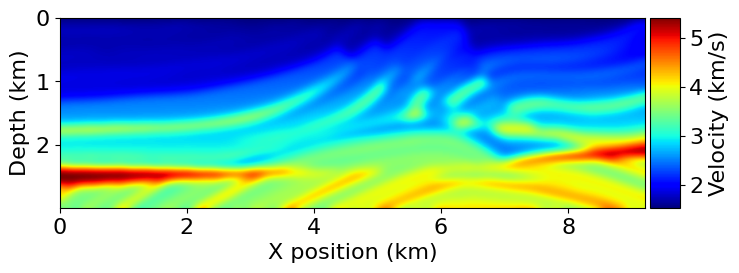

In [2]:
model0 = Model(space_order=space_order, vp=v, b = 1/rho,   
                           origin=origin, shape=shape, spacing=spacing, 
                           nbl=nbl)
filter_sigma = (6, 6)
gaussian_smooth(model0.vp, sigma=filter_sigma)

plot_velocity(model0)

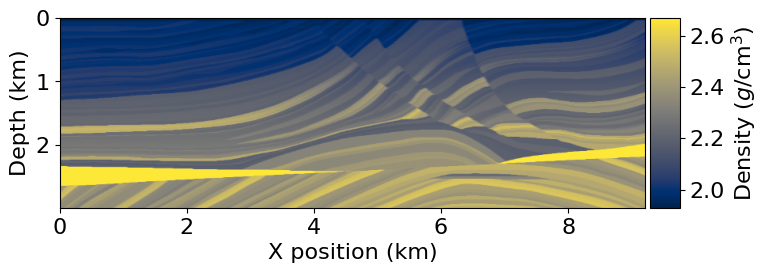

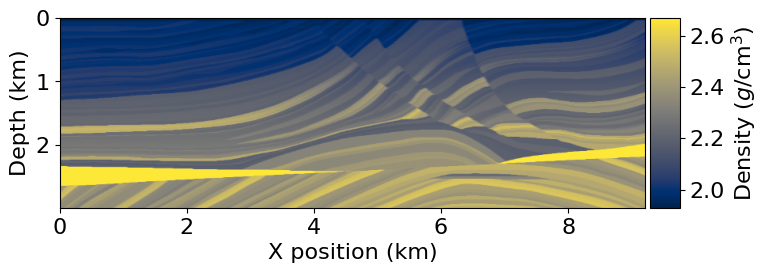

In [3]:
plot_density(model)
plot_density(model0)

In [4]:
from examples.seismic import TimeAxis

t0 = 0. 
tn = 5000.
dt = 0.0008
time_range = TimeAxis(start = t0, stop = tn, step = dt)



In [5]:
from examples.seismic import RickerSource

f0 = 0.030
src = RickerSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 1.


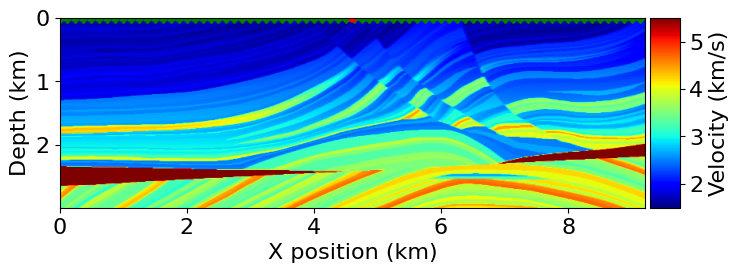

In [6]:
from examples.seismic import Receiver

rec_coordinates = np.empty((model.shape[0], 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=model.shape[0])
rec_coordinates[:, 1] = 1.

plot_velocity(model, source=src.coordinates.data,receiver=rec_coordinates[::10,:])

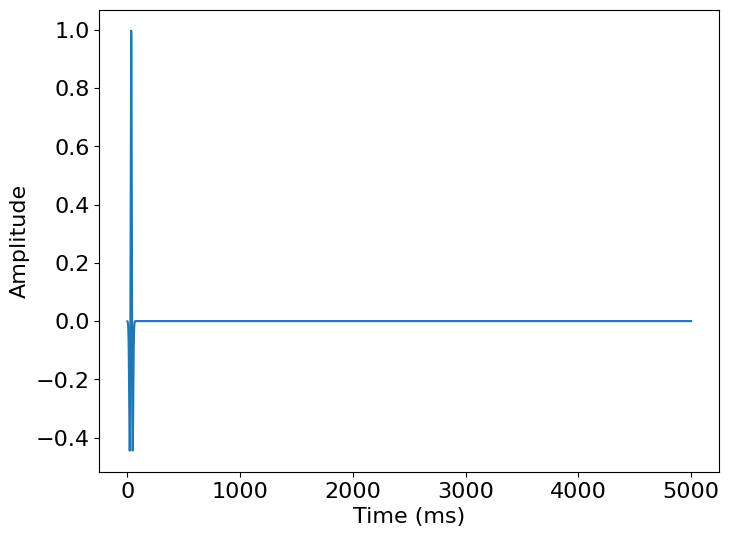

In [7]:
from examples.seismic import AcquisitionGeometry

geometry = AcquisitionGeometry(model, rec_coordinates, src.coordinates.data, t0, tn, f0=f0, src_type='Ricker')
geometry.src.show()

In [8]:
solver = VariableDensityAcousticWaveSolver(model, geometry, space_order = space_order)


In [9]:
from examples.seismic import plot_shotrecord


true_d , _, _ = solver.forward(vp=model.vp)
smooth_d, _, _ = solver.forward(vp=model0.vp)

Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.04 s


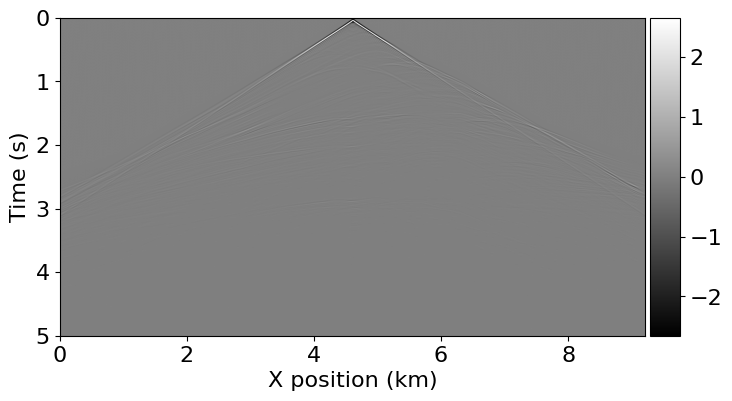

In [10]:

plot_shotrecord(true_d.data, model, t0, tn)

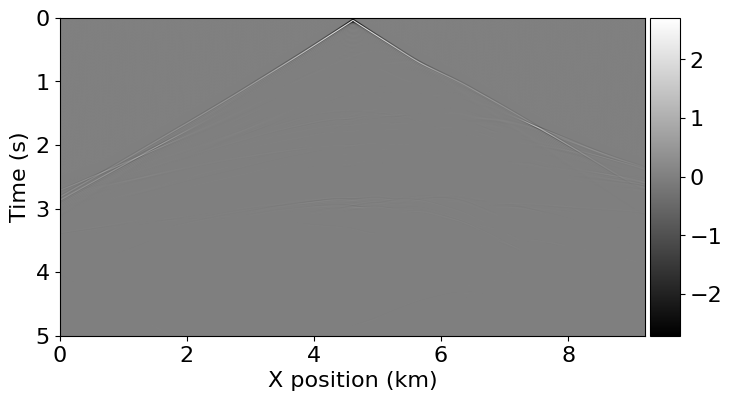

In [11]:
plot_shotrecord(smooth_d.data, model, t0, tn)

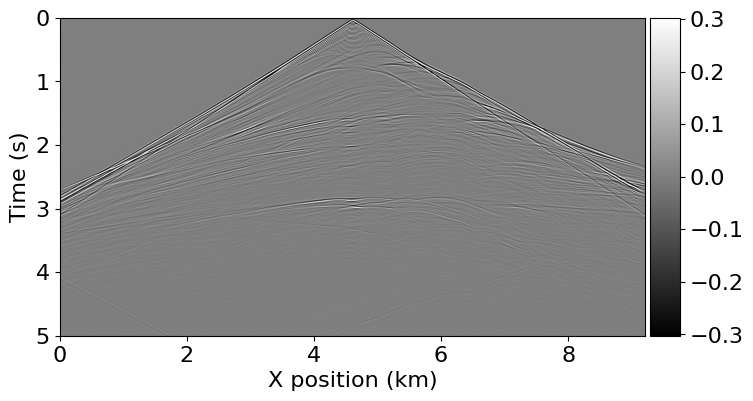

In [12]:
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

In [13]:

from examples.seismic import PointSource

time_order = 2
def ImagingOperator(model: Model, image: Function, geometry: AcquisitionGeometry):
    v = TimeFunction( # Ajoint field
        name='v', grid=model.grid, time_order = 2, space_order = model.space_order
    )
    u = TimeFunction( # Forward field
        name='u', grid=model.grid, time_order = 2, space_order = model.space_order, save = geometry.nt
    )

    # Adjoint wave equation
    kappa = 1/(model.m * model.b)
    eqn = v.dt2 - kappa * div(model.b * grad(v, shift=0.5), shift=-0.5) + model.damp * v.dt.T
    # eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T  # Temp

    stencil = Eq(v.backward, solve(eqn, v.backward))

    dt = model.critical_dt

    # Residual injection
    residual = PointSource(
        name = 'residual',
        grid = model.grid,
        time_range=geometry.time_axis,
        coordinates = geometry.rec_positions
    )

    res_term = residual.inject(field = v.backward, expr = residual * dt**2/model.m)

    # Image condition
    image_update = Eq(image, image + u*v)

    return Operator([stencil] + res_term + [image_update], subs=model.spacing_map)


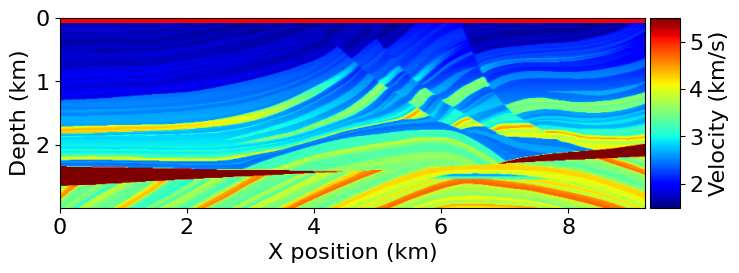

In [14]:
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model.domain_size[0], num=nshots)
source_locations[:, 1] = 1

plot_velocity(model, source=source_locations)

In [15]:

image = Function(name = 'image', grid = model.grid)
op = ImagingOperator(model, image, geometry)

for i in range(nshots):
    if i % 5 == 0:
        print(f'Imaging source {i + 1} out of {nshots}')

    geometry.src_positions[0, :] = source_locations[i, :]

    true_d, _, _ = solver.forward(vp = model.vp)
    smooth_d, u0, _ = solver.forward(vp = model0.vp, save = True)
    # smooth_d, u0, _ = solver.forward(vp = model0.vp)

    v = TimeFunction(name = 'v', grid = model.grid, time_order = 2, space_order = model.space_order)
    
    residual = smooth_d.data - true_d.data
    del true_d, smooth_d, _
    op(u=u0, v=v, vp=model0.vp, b=model0.b, dt=model0.critical_dt, residual=residual)
    # op(u=u0, v=v, vp=model0.vp, dt=model0.critical_dt, residual=residual)
    del u0, v, residual
    gc.collect()


Imaging source 1 out of 738


Operator `Forward` ran in 5.08 s
Operator `Forward` ran in 5.84 s
Operator `Kernel` ran in 6.12 s
Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 6.09 s
Operator `Forward` ran in 4.96 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 5.68 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 6.27 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 6.12 s


Imaging source 6 out of 738


Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 6.08 s
Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 6.43 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.51 s
Operator `Kernel` ran in 6.10 s
Operator `Forward` ran in 5.00 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 5.78 s
Operator `Forward` ran in 4.92 s
Operator `Forward` ran in 5.38 s
Operator `Kernel` ran in 5.63 s


Imaging source 11 out of 738


Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.54 s
Operator `Kernel` ran in 5.69 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.71 s
Operator `Kernel` ran in 5.70 s
Operator `Forward` ran in 5.03 s
Operator `Forward` ran in 5.30 s
Operator `Kernel` ran in 6.01 s
Operator `Forward` ran in 5.28 s
Operator `Forward` ran in 5.72 s
Operator `Kernel` ran in 6.14 s


Imaging source 16 out of 738


Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.56 s
Operator `Kernel` ran in 5.79 s
Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.78 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 4.91 s
Operator `Forward` ran in 5.35 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 5.04 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.56 s
Operator `Kernel` ran in 6.06 s


Imaging source 21 out of 738


Operator `Forward` ran in 5.45 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.55 s
Operator `Kernel` ran in 6.14 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 5.88 s
Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.49 s
Operator `Kernel` ran in 5.98 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.53 s
Operator `Kernel` ran in 5.51 s


Imaging source 26 out of 738


Operator `Forward` ran in 4.52 s
Operator `Forward` ran in 5.30 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.57 s
Operator `Kernel` ran in 5.74 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.20 s
Operator `Kernel` ran in 5.58 s
Operator `Forward` ran in 4.96 s
Operator `Forward` ran in 5.37 s
Operator `Kernel` ran in 5.60 s
Operator `Forward` ran in 4.77 s
Operator `Forward` ran in 5.44 s
Operator `Kernel` ran in 5.58 s


Imaging source 31 out of 738


Operator `Forward` ran in 4.71 s
Operator `Forward` ran in 5.42 s
Operator `Kernel` ran in 6.00 s
Operator `Forward` ran in 4.98 s
Operator `Forward` ran in 5.48 s
Operator `Kernel` ran in 5.75 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.93 s
Operator `Kernel` ran in 5.68 s
Operator `Forward` ran in 5.04 s
Operator `Forward` ran in 5.82 s
Operator `Kernel` ran in 5.87 s
Operator `Forward` ran in 5.36 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 5.88 s


Imaging source 36 out of 738


Operator `Forward` ran in 5.12 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 6.08 s
Operator `Forward` ran in 5.41 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 6.08 s
Operator `Forward` ran in 5.26 s
Operator `Forward` ran in 5.20 s
Operator `Kernel` ran in 5.77 s
Operator `Forward` ran in 5.12 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 5.80 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.49 s
Operator `Kernel` ran in 5.93 s


Imaging source 41 out of 738


Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.51 s
Operator `Kernel` ran in 6.33 s
Operator `Forward` ran in 5.49 s
Operator `Forward` ran in 5.47 s
Operator `Kernel` ran in 5.73 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.83 s
Operator `Kernel` ran in 5.68 s
Operator `Forward` ran in 4.87 s
Operator `Forward` ran in 5.25 s
Operator `Kernel` ran in 5.94 s
Operator `Forward` ran in 5.04 s
Operator `Forward` ran in 5.32 s
Operator `Kernel` ran in 5.53 s


Imaging source 46 out of 738


Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 5.91 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.87 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 6.12 s
Operator `Forward` ran in 5.28 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 6.11 s
Operator `Forward` ran in 5.36 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 5.85 s


Imaging source 51 out of 738


Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 5.79 s
Operator `Forward` ran in 4.84 s
Operator `Forward` ran in 5.37 s
Operator `Kernel` ran in 5.71 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.46 s
Operator `Kernel` ran in 6.12 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.36 s
Operator `Kernel` ran in 5.48 s
Operator `Forward` ran in 4.96 s
Operator `Forward` ran in 5.50 s
Operator `Kernel` ran in 5.70 s


Imaging source 56 out of 738


Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.57 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 5.11 s
Operator `Forward` ran in 5.51 s
Operator `Kernel` ran in 5.79 s
Operator `Forward` ran in 4.87 s
Operator `Forward` ran in 5.48 s
Operator `Kernel` ran in 5.78 s
Operator `Forward` ran in 4.76 s
Operator `Forward` ran in 5.20 s
Operator `Kernel` ran in 5.74 s
Operator `Forward` ran in 4.96 s
Operator `Forward` ran in 5.60 s
Operator `Kernel` ran in 5.79 s


Imaging source 61 out of 738


Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.56 s
Operator `Kernel` ran in 5.75 s
Operator `Forward` ran in 4.85 s
Operator `Forward` ran in 5.40 s
Operator `Kernel` ran in 5.87 s
Operator `Forward` ran in 5.42 s
Operator `Forward` ran in 5.75 s
Operator `Kernel` ran in 5.90 s
Operator `Forward` ran in 5.26 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 5.62 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 6.17 s


Imaging source 66 out of 738


Operator `Forward` ran in 5.35 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 5.81 s
Operator `Forward` ran in 5.04 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 5.71 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.37 s
Operator `Kernel` ran in 6.07 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.50 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.26 s
Operator `Kernel` ran in 5.52 s


Imaging source 71 out of 738


Operator `Forward` ran in 5.03 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 5.87 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 5.85 s
Operator `Forward` ran in 4.93 s
Operator `Forward` ran in 5.34 s
Operator `Kernel` ran in 5.18 s
Operator `Forward` ran in 4.83 s
Operator `Forward` ran in 5.25 s
Operator `Kernel` ran in 5.70 s
Operator `Forward` ran in 4.95 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 6.27 s


Imaging source 76 out of 738


Operator `Forward` ran in 5.56 s
Operator `Forward` ran in 5.89 s
Operator `Kernel` ran in 6.28 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.67 s
Operator `Kernel` ran in 5.53 s
Operator `Forward` ran in 4.98 s
Operator `Forward` ran in 5.56 s
Operator `Kernel` ran in 5.76 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 6.43 s
Operator `Forward` ran in 5.49 s
Operator `Forward` ran in 5.92 s
Operator `Kernel` ran in 5.82 s


Imaging source 81 out of 738


Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.32 s
Operator `Kernel` ran in 5.71 s
Operator `Forward` ran in 5.08 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 5.88 s
Operator `Forward` ran in 5.17 s
Operator `Forward` ran in 5.98 s
Operator `Kernel` ran in 6.43 s
Operator `Forward` ran in 5.38 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 5.96 s
Operator `Forward` ran in 4.59 s
Operator `Forward` ran in 5.26 s
Operator `Kernel` ran in 5.74 s


Imaging source 86 out of 738


Operator `Forward` ran in 4.99 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 5.77 s
Operator `Forward` ran in 5.47 s
Operator `Forward` ran in 5.45 s
Operator `Kernel` ran in 5.88 s
Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 5.11 s
Operator `Kernel` ran in 5.18 s
Operator `Forward` ran in 4.85 s
Operator `Forward` ran in 5.81 s
Operator `Kernel` ran in 5.94 s
Operator `Forward` ran in 5.00 s
Operator `Forward` ran in 5.30 s
Operator `Kernel` ran in 5.63 s


Imaging source 91 out of 738


Operator `Forward` ran in 4.76 s
Operator `Forward` ran in 5.35 s
Operator `Kernel` ran in 5.45 s
Operator `Forward` ran in 4.92 s
Operator `Forward` ran in 6.04 s
Operator `Kernel` ran in 6.52 s
Operator `Forward` ran in 5.61 s
Operator `Forward` ran in 5.66 s
Operator `Kernel` ran in 5.52 s
Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.15 s
Operator `Kernel` ran in 5.43 s
Operator `Forward` ran in 4.66 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 5.82 s


Imaging source 96 out of 738


Operator `Forward` ran in 4.76 s
Operator `Forward` ran in 5.26 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 6.04 s
Operator `Kernel` ran in 6.22 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.42 s
Operator `Kernel` ran in 5.72 s
Operator `Forward` ran in 4.85 s
Operator `Forward` ran in 5.28 s
Operator `Kernel` ran in 5.61 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.91 s
Operator `Kernel` ran in 5.93 s


Imaging source 101 out of 738


Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 5.25 s
Operator `Kernel` ran in 5.49 s
Operator `Forward` ran in 4.77 s
Operator `Forward` ran in 5.60 s
Operator `Kernel` ran in 5.54 s
Operator `Forward` ran in 4.84 s
Operator `Forward` ran in 5.72 s
Operator `Kernel` ran in 5.94 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.55 s
Operator `Kernel` ran in 6.08 s
Operator `Forward` ran in 4.49 s
Operator `Forward` ran in 5.55 s
Operator `Kernel` ran in 6.00 s


Imaging source 106 out of 738


Operator `Forward` ran in 4.76 s
Operator `Forward` ran in 5.41 s
Operator `Kernel` ran in 6.10 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 5.95 s
Operator `Forward` ran in 5.06 s
Operator `Forward` ran in 5.50 s
Operator `Kernel` ran in 5.77 s
Operator `Forward` ran in 4.58 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 5.43 s
Operator `Kernel` ran in 5.98 s


Imaging source 111 out of 738


Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.26 s
Operator `Kernel` ran in 5.79 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 6.08 s
Operator `Forward` ran in 5.40 s
Operator `Forward` ran in 5.48 s
Operator `Kernel` ran in 6.00 s
Operator `Forward` ran in 5.12 s
Operator `Forward` ran in 5.35 s
Operator `Kernel` ran in 5.50 s
Operator `Forward` ran in 5.08 s
Operator `Forward` ran in 5.55 s
Operator `Kernel` ran in 5.90 s


Imaging source 116 out of 738


Operator `Forward` ran in 4.98 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 5.68 s
Operator `Forward` ran in 5.30 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 6.09 s
Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.87 s
Operator `Kernel` ran in 6.19 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.48 s
Operator `Kernel` ran in 6.01 s
Operator `Forward` ran in 5.04 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 6.22 s


Imaging source 121 out of 738


Operator `Forward` ran in 4.97 s
Operator `Forward` ran in 5.97 s
Operator `Kernel` ran in 6.43 s
Operator `Forward` ran in 5.52 s
Operator `Forward` ran in 5.99 s
Operator `Kernel` ran in 6.12 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.78 s
Operator `Kernel` ran in 6.32 s
Operator `Forward` ran in 5.46 s
Operator `Forward` ran in 5.89 s
Operator `Kernel` ran in 6.21 s


Imaging source 126 out of 738


Operator `Forward` ran in 5.35 s
Operator `Forward` ran in 5.57 s
Operator `Kernel` ran in 5.66 s
Operator `Forward` ran in 4.71 s
Operator `Forward` ran in 5.45 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 5.51 s
Operator `Forward` ran in 5.99 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.00 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 5.90 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 6.06 s


Imaging source 131 out of 738


Operator `Forward` ran in 5.08 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 5.68 s
Operator `Forward` ran in 5.41 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.23 s
Operator `Forward` ran in 5.61 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 5.98 s
Operator `Forward` ran in 4.92 s
Operator `Forward` ran in 5.51 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.44 s
Operator `Forward` ran in 5.99 s
Operator `Kernel` ran in 5.94 s


Imaging source 136 out of 738


Operator `Forward` ran in 5.52 s
Operator `Forward` ran in 5.75 s
Operator `Kernel` ran in 6.07 s
Operator `Forward` ran in 4.90 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 5.89 s
Operator `Forward` ran in 5.00 s
Operator `Forward` ran in 5.47 s
Operator `Kernel` ran in 5.88 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.79 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.05 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 5.62 s


Imaging source 141 out of 738


Operator `Forward` ran in 5.03 s
Operator `Forward` ran in 5.92 s
Operator `Kernel` ran in 6.27 s
Operator `Forward` ran in 4.98 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.81 s
Operator `Forward` ran in 5.08 s
Operator `Forward` ran in 5.28 s
Operator `Kernel` ran in 5.82 s
Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 5.90 s
Operator `Forward` ran in 4.78 s
Operator `Forward` ran in 5.83 s
Operator `Kernel` ran in 6.28 s


Imaging source 146 out of 738


Operator `Forward` ran in 5.46 s
Operator `Forward` ran in 5.79 s
Operator `Kernel` ran in 5.95 s
Operator `Forward` ran in 4.88 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 4.98 s
Operator `Forward` ran in 5.66 s
Operator `Kernel` ran in 6.44 s
Operator `Forward` ran in 5.68 s
Operator `Forward` ran in 5.96 s
Operator `Kernel` ran in 6.29 s
Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.82 s
Operator `Kernel` ran in 6.09 s


Imaging source 151 out of 738


Operator `Forward` ran in 5.61 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 6.22 s
Operator `Forward` ran in 5.60 s
Operator `Forward` ran in 6.04 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.42 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 5.25 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 5.70 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 5.92 s


Imaging source 156 out of 738


Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.84 s
Operator `Kernel` ran in 7.75 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 6.13 s
Operator `Kernel` ran in 6.81 s
Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 6.18 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.66 s
Operator `Kernel` ran in 5.86 s
Operator `Forward` ran in 4.99 s
Operator `Forward` ran in 5.75 s
Operator `Kernel` ran in 6.00 s


Imaging source 161 out of 738


Operator `Forward` ran in 5.43 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 6.38 s
Operator `Forward` ran in 5.00 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 6.11 s
Operator `Forward` ran in 5.35 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 6.00 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 6.02 s
Operator `Kernel` ran in 6.55 s
Operator `Forward` ran in 5.56 s
Operator `Forward` ran in 6.05 s
Operator `Kernel` ran in 6.32 s


Imaging source 166 out of 738


Operator `Forward` ran in 5.53 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 6.10 s
Operator `Forward` ran in 5.08 s
Operator `Forward` ran in 5.83 s
Operator `Kernel` ran in 6.20 s
Operator `Forward` ran in 4.88 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.99 s
Operator `Forward` ran in 4.60 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 5.49 s
Operator `Forward` ran in 4.89 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.96 s


Imaging source 171 out of 738


Operator `Forward` ran in 5.17 s
Operator `Forward` ran in 5.57 s
Operator `Kernel` ran in 5.88 s
Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 5.78 s
Operator `Forward` ran in 4.91 s
Operator `Forward` ran in 5.36 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 5.35 s
Operator `Forward` ran in 5.87 s
Operator `Kernel` ran in 6.31 s
Operator `Forward` ran in 5.58 s
Operator `Forward` ran in 6.01 s
Operator `Kernel` ran in 6.14 s


Imaging source 176 out of 738


Operator `Forward` ran in 5.33 s
Operator `Forward` ran in 5.57 s
Operator `Kernel` ran in 5.80 s
Operator `Forward` ran in 4.93 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 5.41 s
Operator `Forward` ran in 5.98 s
Operator `Kernel` ran in 6.26 s
Operator `Forward` ran in 5.45 s
Operator `Forward` ran in 5.55 s
Operator `Kernel` ran in 5.85 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.88 s


Imaging source 181 out of 738


Operator `Forward` ran in 4.97 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 6.22 s
Operator `Forward` ran in 5.48 s
Operator `Forward` ran in 5.55 s
Operator `Kernel` ran in 5.89 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 5.94 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 5.67 s
Operator `Kernel` ran in 5.99 s


Imaging source 186 out of 738


Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.16 s
Operator `Forward` ran in 5.38 s
Operator `Forward` ran in 5.55 s
Operator `Kernel` ran in 5.68 s
Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.27 s
Operator `Kernel` ran in 5.62 s
Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 5.92 s
Operator `Kernel` ran in 6.22 s
Operator `Forward` ran in 5.58 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 6.18 s


Imaging source 191 out of 738


Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 5.78 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 5.94 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 5.60 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 6.26 s


Imaging source 196 out of 738


Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 4.81 s
Operator `Forward` ran in 5.31 s
Operator `Kernel` ran in 5.54 s
Operator `Forward` ran in 4.63 s
Operator `Forward` ran in 5.54 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 5.06 s
Operator `Forward` ran in 5.79 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 5.26 s
Operator `Forward` ran in 5.53 s
Operator `Kernel` ran in 6.14 s


Imaging source 201 out of 738


Operator `Forward` ran in 5.61 s
Operator `Forward` ran in 5.96 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.14 s
Operator `Kernel` ran in 5.46 s
Operator `Forward` ran in 4.73 s
Operator `Forward` ran in 5.79 s
Operator `Kernel` ran in 5.97 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.56 s
Operator `Kernel` ran in 5.78 s
Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 5.78 s
Operator `Kernel` ran in 6.09 s


Imaging source 206 out of 738


Operator `Forward` ran in 5.33 s
Operator `Forward` ran in 5.81 s
Operator `Kernel` ran in 6.11 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 5.79 s
Operator `Kernel` ran in 5.99 s
Operator `Forward` ran in 5.25 s
Operator `Forward` ran in 5.57 s
Operator `Kernel` ran in 5.43 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 4.94 s
Operator `Forward` ran in 5.84 s
Operator `Kernel` ran in 6.04 s


Imaging source 211 out of 738


Operator `Forward` ran in 5.41 s
Operator `Forward` ran in 5.78 s
Operator `Kernel` ran in 5.74 s
Operator `Forward` ran in 5.34 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 6.14 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 6.32 s
Operator `Forward` ran in 5.37 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.93 s
Operator `Kernel` ran in 6.29 s


Imaging source 216 out of 738


Operator `Forward` ran in 5.25 s
Operator `Forward` ran in 5.72 s
Operator `Kernel` ran in 5.89 s
Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.90 s
Operator `Kernel` ran in 5.87 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.05 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 6.66 s
Operator `Forward` ran in 5.73 s
Operator `Forward` ran in 6.13 s
Operator `Kernel` ran in 5.93 s


Imaging source 221 out of 738


Operator `Forward` ran in 5.29 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 5.55 s
Operator `Forward` ran in 4.94 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 5.95 s
Operator `Forward` ran in 4.78 s
Operator `Forward` ran in 5.49 s
Operator `Kernel` ran in 5.46 s
Operator `Forward` ran in 5.29 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 5.89 s
Operator `Forward` ran in 5.37 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 6.19 s


Imaging source 226 out of 738


Operator `Forward` ran in 4.93 s
Operator `Forward` ran in 5.72 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 5.04 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.11 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.87 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 6.15 s
Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.67 s
Operator `Kernel` ran in 5.71 s


Imaging source 231 out of 738


Operator `Forward` ran in 5.11 s
Operator `Forward` ran in 5.55 s
Operator `Kernel` ran in 5.99 s
Operator `Forward` ran in 5.30 s
Operator `Forward` ran in 5.75 s
Operator `Kernel` ran in 6.49 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.30 s
Operator `Kernel` ran in 5.56 s
Operator `Forward` ran in 4.60 s
Operator `Forward` ran in 5.34 s
Operator `Kernel` ran in 5.90 s
Operator `Forward` ran in 4.95 s
Operator `Forward` ran in 5.60 s
Operator `Kernel` ran in 6.11 s


Imaging source 236 out of 738


Operator `Forward` ran in 5.25 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 5.95 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.66 s
Operator `Kernel` ran in 5.64 s
Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 6.24 s
Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.82 s
Operator `Kernel` ran in 5.88 s
Operator `Forward` ran in 4.97 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 5.93 s


Imaging source 241 out of 738


Operator `Forward` ran in 5.26 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 6.11 s
Operator `Forward` ran in 4.88 s
Operator `Forward` ran in 5.72 s
Operator `Kernel` ran in 6.13 s
Operator `Forward` ran in 4.82 s
Operator `Forward` ran in 5.71 s
Operator `Kernel` ran in 6.07 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 4.98 s
Operator `Forward` ran in 5.54 s
Operator `Kernel` ran in 5.77 s


Imaging source 246 out of 738


Operator `Forward` ran in 5.12 s
Operator `Forward` ran in 5.56 s
Operator `Kernel` ran in 5.82 s
Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 5.50 s
Operator `Kernel` ran in 5.78 s
Operator `Forward` ran in 5.38 s
Operator `Forward` ran in 5.91 s
Operator `Kernel` ran in 5.94 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.83 s
Operator `Kernel` ran in 5.74 s
Operator `Forward` ran in 4.98 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.14 s


Imaging source 251 out of 738


Operator `Forward` ran in 5.06 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 5.98 s
Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.78 s
Operator `Kernel` ran in 6.20 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.50 s
Operator `Kernel` ran in 5.74 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 5.56 s
Operator `Forward` ran in 4.94 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 5.85 s


Imaging source 256 out of 738


Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 6.01 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.60 s
Operator `Kernel` ran in 6.26 s
Operator `Forward` ran in 5.46 s
Operator `Forward` ran in 5.84 s
Operator `Kernel` ran in 6.08 s
Operator `Forward` ran in 5.06 s
Operator `Forward` ran in 5.91 s
Operator `Kernel` ran in 6.14 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 6.29 s


Imaging source 261 out of 738


Operator `Forward` ran in 5.55 s
Operator `Forward` ran in 5.97 s
Operator `Kernel` ran in 6.30 s
Operator `Forward` ran in 5.28 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.12 s
Operator `Forward` ran in 5.58 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.56 s
Operator `Forward` ran in 5.59 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 6.38 s
Operator `Forward` ran in 5.31 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 5.92 s


Imaging source 266 out of 738


Operator `Forward` ran in 5.06 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 5.99 s
Operator `Forward` ran in 4.63 s
Operator `Forward` ran in 5.50 s
Operator `Kernel` ran in 5.44 s
Operator `Forward` ran in 4.99 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 6.00 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.97 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.36 s
Operator `Forward` ran in 5.19 s
Operator `Kernel` ran in 5.54 s


Imaging source 271 out of 738


Operator `Forward` ran in 4.93 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.84 s
Operator `Forward` ran in 5.36 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.11 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 5.85 s
Operator `Forward` ran in 4.91 s
Operator `Forward` ran in 5.54 s
Operator `Kernel` ran in 5.52 s
Operator `Forward` ran in 4.88 s
Operator `Forward` ran in 5.22 s
Operator `Kernel` ran in 5.87 s


Imaging source 276 out of 738


Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.93 s
Operator `Kernel` ran in 6.42 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.67 s
Operator `Kernel` ran in 5.97 s
Operator `Forward` ran in 5.00 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 5.50 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.81 s
Operator `Kernel` ran in 6.01 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 5.66 s


Imaging source 281 out of 738


Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.48 s
Operator `Kernel` ran in 5.90 s
Operator `Forward` ran in 5.05 s
Operator `Forward` ran in 5.53 s
Operator `Kernel` ran in 6.29 s
Operator `Forward` ran in 5.56 s
Operator `Forward` ran in 5.97 s
Operator `Kernel` ran in 6.49 s
Operator `Forward` ran in 5.60 s
Operator `Forward` ran in 6.08 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 5.08 s
Operator `Forward` ran in 5.38 s
Operator `Kernel` ran in 5.44 s


Imaging source 286 out of 738


Operator `Forward` ran in 5.51 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 6.36 s
Operator `Forward` ran in 5.25 s
Operator `Forward` ran in 5.38 s
Operator `Kernel` ran in 5.86 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.41 s
Operator `Kernel` ran in 5.44 s
Operator `Forward` ran in 4.52 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 6.47 s
Operator `Forward` ran in 5.54 s
Operator `Forward` ran in 6.06 s
Operator `Kernel` ran in 5.70 s


Imaging source 291 out of 738


Operator `Forward` ran in 4.98 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 5.86 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 6.11 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.13 s
Operator `Forward` ran in 5.57 s
Operator `Forward` ran in 5.55 s
Operator `Kernel` ran in 5.90 s
Operator `Forward` ran in 5.11 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 5.89 s


Imaging source 296 out of 738


Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 6.40 s
Operator `Forward` ran in 5.60 s
Operator `Forward` ran in 6.05 s
Operator `Kernel` ran in 6.54 s
Operator `Forward` ran in 5.66 s
Operator `Forward` ran in 5.78 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 5.30 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 6.30 s
Operator `Forward` ran in 5.46 s
Operator `Forward` ran in 5.45 s
Operator `Kernel` ran in 6.43 s


Imaging source 301 out of 738


Operator `Forward` ran in 5.63 s
Operator `Forward` ran in 5.83 s
Operator `Kernel` ran in 5.88 s
Operator `Forward` ran in 5.39 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 6.28 s
Operator `Forward` ran in 5.60 s
Operator `Forward` ran in 6.13 s
Operator `Kernel` ran in 6.31 s
Operator `Forward` ran in 5.28 s
Operator `Forward` ran in 5.87 s
Operator `Kernel` ran in 6.20 s
Operator `Forward` ran in 5.31 s
Operator `Forward` ran in 5.88 s
Operator `Kernel` ran in 6.45 s


Imaging source 306 out of 738


Operator `Forward` ran in 5.66 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 6.21 s
Operator `Forward` ran in 5.67 s
Operator `Forward` ran in 5.98 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 5.50 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.39 s
Operator `Forward` ran in 5.49 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.75 s
Operator `Kernel` ran in 5.95 s


Imaging source 311 out of 738


Operator `Forward` ran in 5.04 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 6.10 s
Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 5.62 s
Operator `Forward` ran in 5.06 s
Operator `Forward` ran in 6.16 s
Operator `Kernel` ran in 6.45 s
Operator `Forward` ran in 5.48 s
Operator `Forward` ran in 5.66 s
Operator `Kernel` ran in 5.69 s
Operator `Forward` ran in 4.77 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 6.24 s


Imaging source 316 out of 738


Operator `Forward` ran in 5.51 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.32 s
Operator `Forward` ran in 5.52 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 5.04 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 5.67 s
Operator `Forward` ran in 5.41 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 6.21 s
Operator `Forward` ran in 5.47 s
Operator `Forward` ran in 6.04 s
Operator `Kernel` ran in 6.52 s


Imaging source 321 out of 738


Operator `Forward` ran in 5.59 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 4.96 s
Operator `Kernel` ran in 5.32 s
Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 6.37 s
Operator `Forward` ran in 5.44 s
Operator `Forward` ran in 5.98 s
Operator `Kernel` ran in 6.29 s
Operator `Forward` ran in 5.12 s
Operator `Forward` ran in 5.84 s
Operator `Kernel` ran in 6.07 s


Imaging source 326 out of 738


Operator `Forward` ran in 5.25 s
Operator `Forward` ran in 6.12 s
Operator `Kernel` ran in 6.07 s
Operator `Forward` ran in 5.12 s
Operator `Forward` ran in 5.84 s
Operator `Kernel` ran in 6.01 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.97 s
Operator `Kernel` ran in 5.96 s
Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 5.49 s
Operator `Forward` ran in 4.69 s
Operator `Forward` ran in 5.51 s
Operator `Kernel` ran in 5.77 s


Imaging source 331 out of 738


Operator `Forward` ran in 4.84 s
Operator `Forward` ran in 5.43 s
Operator `Kernel` ran in 5.84 s
Operator `Forward` ran in 5.04 s
Operator `Forward` ran in 5.98 s
Operator `Kernel` ran in 6.39 s
Operator `Forward` ran in 5.61 s
Operator `Forward` ran in 6.09 s
Operator `Kernel` ran in 6.34 s
Operator `Forward` ran in 5.44 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 6.07 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 5.75 s


Imaging source 336 out of 738


Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 5.98 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 6.11 s
Operator `Forward` ran in 5.51 s
Operator `Forward` ran in 6.12 s
Operator `Kernel` ran in 6.28 s
Operator `Forward` ran in 5.59 s
Operator `Forward` ran in 5.94 s
Operator `Kernel` ran in 6.43 s


Imaging source 341 out of 738


Operator `Forward` ran in 5.62 s
Operator `Forward` ran in 5.81 s
Operator `Kernel` ran in 6.34 s
Operator `Forward` ran in 5.39 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 6.34 s
Operator `Forward` ran in 5.52 s
Operator `Forward` ran in 6.08 s
Operator `Kernel` ran in 6.47 s
Operator `Forward` ran in 5.60 s
Operator `Forward` ran in 5.96 s
Operator `Kernel` ran in 5.98 s
Operator `Forward` ran in 4.86 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.88 s


Imaging source 346 out of 738


Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 5.62 s
Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 5.98 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.72 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 5.90 s


Imaging source 351 out of 738


Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 6.00 s
Operator `Forward` ran in 5.05 s
Operator `Forward` ran in 5.66 s
Operator `Kernel` ran in 6.17 s
Operator `Forward` ran in 5.53 s
Operator `Forward` ran in 6.06 s
Operator `Kernel` ran in 6.42 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 5.81 s
Operator `Forward` ran in 5.11 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 5.88 s


Imaging source 356 out of 738


Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.38 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 4.97 s
Operator `Forward` ran in 5.54 s
Operator `Kernel` ran in 5.79 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 5.91 s
Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.96 s
Operator `Kernel` ran in 6.25 s
Operator `Forward` ran in 5.50 s
Operator `Forward` ran in 5.47 s
Operator `Kernel` ran in 5.85 s


Imaging source 361 out of 738


Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 5.80 s
Operator `Forward` ran in 4.94 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 6.01 s
Operator `Forward` ran in 5.12 s
Operator `Forward` ran in 5.81 s
Operator `Kernel` ran in 6.23 s
Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.82 s
Operator `Kernel` ran in 6.37 s
Operator `Forward` ran in 5.71 s
Operator `Forward` ran in 6.18 s
Operator `Kernel` ran in 6.40 s


Imaging source 366 out of 738


Operator `Forward` ran in 5.56 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 5.30 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.40 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 6.08 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 6.05 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 6.13 s


Imaging source 371 out of 738


Operator `Forward` ran in 5.48 s
Operator `Forward` ran in 6.08 s
Operator `Kernel` ran in 6.44 s
Operator `Forward` ran in 5.53 s
Operator `Forward` ran in 6.15 s
Operator `Kernel` ran in 6.30 s
Operator `Forward` ran in 5.51 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 5.81 s
Operator `Forward` ran in 4.80 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 5.69 s
Operator `Forward` ran in 5.40 s
Operator `Forward` ran in 5.94 s
Operator `Kernel` ran in 6.36 s


Imaging source 376 out of 738


Operator `Forward` ran in 5.39 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 5.76 s
Operator `Forward` ran in 4.67 s
Operator `Forward` ran in 5.56 s
Operator `Kernel` ran in 5.78 s
Operator `Forward` ran in 4.93 s
Operator `Forward` ran in 6.16 s
Operator `Kernel` ran in 6.44 s
Operator `Forward` ran in 5.51 s
Operator `Forward` ran in 6.11 s
Operator `Kernel` ran in 6.54 s
Operator `Forward` ran in 5.62 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 5.96 s


Imaging source 381 out of 738


Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 6.31 s
Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 6.17 s
Operator `Forward` ran in 5.46 s
Operator `Forward` ran in 5.92 s
Operator `Kernel` ran in 6.54 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.79 s
Operator `Forward` ran in 5.52 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 6.41 s


Imaging source 386 out of 738


Operator `Forward` ran in 4.86 s
Operator `Forward` ran in 5.81 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 4.60 s
Operator `Forward` ran in 5.20 s
Operator `Kernel` ran in 5.58 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.94 s
Operator `Kernel` ran in 5.96 s
Operator `Forward` ran in 5.56 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 5.84 s
Operator `Forward` ran in 4.69 s
Operator `Forward` ran in 5.25 s
Operator `Kernel` ran in 5.82 s


Imaging source 391 out of 738


Operator `Forward` ran in 4.91 s
Operator `Forward` ran in 5.57 s
Operator `Kernel` ran in 5.89 s
Operator `Forward` ran in 5.08 s
Operator `Forward` ran in 5.89 s
Operator `Kernel` ran in 6.24 s
Operator `Forward` ran in 5.45 s
Operator `Forward` ran in 5.60 s
Operator `Kernel` ran in 6.07 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.90 s
Operator `Kernel` ran in 5.90 s
Operator `Forward` ran in 5.35 s
Operator `Forward` ran in 5.92 s
Operator `Kernel` ran in 6.02 s


Imaging source 396 out of 738


Operator `Forward` ran in 5.25 s
Operator `Forward` ran in 5.78 s
Operator `Kernel` ran in 6.15 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.12 s
Operator `Forward` ran in 5.94 s
Operator `Kernel` ran in 6.28 s
Operator `Forward` ran in 5.52 s
Operator `Forward` ran in 5.92 s
Operator `Kernel` ran in 6.24 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 5.79 s


Imaging source 401 out of 738


Operator `Forward` ran in 5.47 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 6.29 s
Operator `Forward` ran in 5.51 s
Operator `Forward` ran in 6.02 s
Operator `Kernel` ran in 6.32 s
Operator `Forward` ran in 5.33 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 6.18 s
Operator `Forward` ran in 5.50 s
Operator `Forward` ran in 5.79 s
Operator `Kernel` ran in 5.99 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 5.94 s


Imaging source 406 out of 738


Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.87 s
Operator `Forward` ran in 5.41 s
Operator `Forward` ran in 5.82 s
Operator `Kernel` ran in 6.00 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.78 s
Operator `Kernel` ran in 6.08 s
Operator `Forward` ran in 5.69 s
Operator `Forward` ran in 6.06 s
Operator `Kernel` ran in 6.56 s
Operator `Forward` ran in 5.49 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 5.94 s


Imaging source 411 out of 738


Operator `Forward` ran in 5.29 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 6.28 s
Operator `Forward` ran in 5.52 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.44 s
Operator `Forward` ran in 5.55 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.28 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 6.10 s
Operator `Forward` ran in 5.50 s
Operator `Forward` ran in 6.06 s
Operator `Kernel` ran in 6.43 s


Imaging source 416 out of 738


Operator `Forward` ran in 5.25 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 6.16 s
Operator `Forward` ran in 5.39 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 6.10 s
Operator `Forward` ran in 5.42 s
Operator `Forward` ran in 6.07 s
Operator `Kernel` ran in 6.51 s
Operator `Forward` ran in 5.68 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.15 s
Operator `Forward` ran in 5.34 s
Operator `Forward` ran in 5.79 s
Operator `Kernel` ran in 6.31 s


Imaging source 421 out of 738


Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.78 s
Operator `Kernel` ran in 5.96 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 5.03 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 6.50 s
Operator `Forward` ran in 5.69 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.51 s
Operator `Kernel` ran in 5.93 s


Imaging source 426 out of 738


Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 5.49 s
Operator `Forward` ran in 5.81 s
Operator `Kernel` ran in 5.94 s
Operator `Forward` ran in 5.35 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 6.07 s
Operator `Forward` ran in 5.06 s
Operator `Forward` ran in 5.51 s
Operator `Kernel` ran in 5.82 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.38 s
Operator `Kernel` ran in 5.95 s


Imaging source 431 out of 738


Operator `Forward` ran in 5.06 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 5.68 s
Operator `Forward` ran in 5.08 s
Operator `Forward` ran in 5.34 s
Operator `Kernel` ran in 5.67 s
Operator `Forward` ran in 4.48 s
Operator `Forward` ran in 5.33 s
Operator `Kernel` ran in 6.25 s
Operator `Forward` ran in 5.42 s
Operator `Forward` ran in 5.97 s
Operator `Kernel` ran in 6.32 s
Operator `Forward` ran in 5.52 s
Operator `Forward` ran in 6.06 s
Operator `Kernel` ran in 6.31 s


Imaging source 436 out of 738


Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 6.41 s
Operator `Forward` ran in 5.49 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 6.45 s
Operator `Forward` ran in 5.59 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 6.40 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.60 s
Operator `Kernel` ran in 5.94 s
Operator `Forward` ran in 5.37 s
Operator `Forward` ran in 6.05 s
Operator `Kernel` ran in 6.51 s


Imaging source 441 out of 738


Operator `Forward` ran in 5.69 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 6.43 s
Operator `Forward` ran in 5.46 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 5.90 s
Operator `Forward` ran in 5.00 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 5.87 s
Operator `Forward` ran in 4.99 s
Operator `Forward` ran in 5.46 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 5.83 s


Imaging source 446 out of 738


Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.82 s
Operator `Kernel` ran in 6.13 s
Operator `Forward` ran in 5.49 s
Operator `Forward` ran in 6.01 s
Operator `Kernel` ran in 6.37 s
Operator `Forward` ran in 5.59 s
Operator `Forward` ran in 5.99 s
Operator `Kernel` ran in 6.33 s
Operator `Forward` ran in 5.52 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 5.90 s
Operator `Forward` ran in 5.30 s
Operator `Forward` ran in 5.72 s
Operator `Kernel` ran in 6.07 s


Imaging source 451 out of 738


Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 6.34 s
Operator `Forward` ran in 5.41 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 5.86 s
Operator `Forward` ran in 5.37 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 6.40 s
Operator `Forward` ran in 5.71 s
Operator `Forward` ran in 6.05 s
Operator `Kernel` ran in 6.34 s
Operator `Forward` ran in 5.58 s
Operator `Forward` ran in 6.01 s
Operator `Kernel` ran in 6.07 s


Imaging source 456 out of 738


Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 6.13 s
Operator `Kernel` ran in 6.45 s
Operator `Forward` ran in 5.49 s
Operator `Forward` ran in 5.60 s
Operator `Kernel` ran in 5.63 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 6.17 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 5.83 s
Operator `Forward` ran in 5.29 s
Operator `Forward` ran in 5.98 s
Operator `Kernel` ran in 6.17 s


Imaging source 461 out of 738


Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.60 s
Operator `Kernel` ran in 6.01 s
Operator `Forward` ran in 4.79 s
Operator `Forward` ran in 5.89 s
Operator `Kernel` ran in 5.84 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.21 s
Operator `Kernel` ran in 5.18 s
Operator `Forward` ran in 5.34 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.15 s
Operator `Forward` ran in 5.28 s
Operator `Forward` ran in 5.40 s
Operator `Kernel` ran in 5.79 s


Imaging source 466 out of 738


Operator `Forward` ran in 4.86 s
Operator `Forward` ran in 5.47 s
Operator `Kernel` ran in 6.22 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 5.44 s
Operator `Kernel` ran in 6.07 s
Operator `Forward` ran in 5.53 s
Operator `Forward` ran in 6.15 s
Operator `Kernel` ran in 6.07 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 6.16 s
Operator `Forward` ran in 5.06 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.45 s


Imaging source 471 out of 738


Operator `Forward` ran in 5.47 s
Operator `Forward` ran in 5.88 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 4.93 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 5.82 s
Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 5.73 s
Operator `Forward` ran in 4.99 s
Operator `Forward` ran in 5.51 s
Operator `Kernel` ran in 5.96 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.87 s
Operator `Kernel` ran in 5.93 s


Imaging source 476 out of 738


Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.90 s
Operator `Kernel` ran in 6.43 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.35 s
Operator `Forward` ran in 4.74 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 5.67 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.82 s
Operator `Kernel` ran in 6.17 s
Operator `Forward` ran in 5.39 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 5.95 s


Imaging source 481 out of 738


Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 5.28 s
Operator `Forward` ran in 5.71 s
Operator `Kernel` ran in 6.34 s
Operator `Forward` ran in 5.72 s
Operator `Forward` ran in 6.14 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 6.11 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 5.95 s


Imaging source 486 out of 738


Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 5.84 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.67 s
Operator `Kernel` ran in 5.99 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.75 s
Operator `Kernel` ran in 6.12 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 5.29 s
Operator `Forward` ran in 5.92 s
Operator `Kernel` ran in 6.16 s


Imaging source 491 out of 738


Operator `Forward` ran in 5.56 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 5.93 s
Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.71 s
Operator `Kernel` ran in 5.98 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 5.96 s
Operator `Forward` ran in 5.38 s
Operator `Forward` ran in 6.07 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 5.47 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 6.10 s


Imaging source 496 out of 738


Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 5.90 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 6.34 s
Operator `Forward` ran in 5.61 s
Operator `Forward` ran in 6.08 s
Operator `Kernel` ran in 6.51 s
Operator `Forward` ran in 4.84 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 5.70 s


Imaging source 501 out of 738


Operator `Forward` ran in 4.96 s
Operator `Forward` ran in 6.96 s
Operator `Kernel` ran in 6.50 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.47 s
Operator `Kernel` ran in 6.80 s
Operator `Forward` ran in 5.41 s
Operator `Forward` ran in 5.90 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 4.97 s
Operator `Forward` ran in 5.32 s
Operator `Kernel` ran in 5.50 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.84 s
Operator `Kernel` ran in 6.41 s


Imaging source 506 out of 738


Operator `Forward` ran in 5.71 s
Operator `Forward` ran in 5.92 s
Operator `Kernel` ran in 6.46 s
Operator `Forward` ran in 5.38 s
Operator `Forward` ran in 5.51 s
Operator `Kernel` ran in 6.18 s
Operator `Forward` ran in 5.45 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.40 s
Operator `Forward` ran in 5.69 s
Operator `Forward` ran in 6.16 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.94 s
Operator `Kernel` ran in 6.04 s


Imaging source 511 out of 738


Operator `Forward` ran in 5.16 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 6.43 s
Operator `Forward` ran in 5.77 s
Operator `Forward` ran in 6.07 s
Operator `Kernel` ran in 6.36 s
Operator `Forward` ran in 5.40 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 5.26 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 6.45 s
Operator `Forward` ran in 5.50 s
Operator `Forward` ran in 6.02 s
Operator `Kernel` ran in 6.18 s


Imaging source 516 out of 738


Operator `Forward` ran in 5.51 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 5.58 s
Operator `Forward` ran in 4.95 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 6.24 s
Operator `Forward` ran in 5.43 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.26 s
Operator `Forward` ran in 4.93 s
Operator `Forward` ran in 5.66 s
Operator `Kernel` ran in 5.91 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 6.17 s


Imaging source 521 out of 738


Operator `Forward` ran in 5.29 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 6.46 s
Operator `Forward` ran in 5.68 s
Operator `Forward` ran in 5.79 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.91 s
Operator `Kernel` ran in 6.14 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.23 s
Operator `Forward` ran in 5.43 s
Operator `Forward` ran in 5.57 s
Operator `Kernel` ran in 6.05 s


Imaging source 526 out of 738


Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 5.85 s
Operator `Forward` ran in 5.42 s
Operator `Forward` ran in 5.53 s
Operator `Kernel` ran in 6.19 s
Operator `Forward` ran in 5.33 s
Operator `Forward` ran in 5.94 s
Operator `Kernel` ran in 5.97 s
Operator `Forward` ran in 5.17 s
Operator `Forward` ran in 5.71 s
Operator `Kernel` ran in 5.69 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.17 s


Imaging source 531 out of 738


Operator `Forward` ran in 5.03 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 5.85 s
Operator `Forward` ran in 4.41 s
Operator `Forward` ran in 5.30 s
Operator `Kernel` ran in 5.65 s
Operator `Forward` ran in 4.72 s
Operator `Forward` ran in 5.29 s
Operator `Kernel` ran in 5.50 s
Operator `Forward` ran in 5.31 s
Operator `Forward` ran in 6.12 s
Operator `Kernel` ran in 6.36 s
Operator `Forward` ran in 5.51 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 5.59 s


Imaging source 536 out of 738


Operator `Forward` ran in 4.86 s
Operator `Forward` ran in 5.45 s
Operator `Kernel` ran in 5.90 s
Operator `Forward` ran in 5.06 s
Operator `Forward` ran in 5.48 s
Operator `Kernel` ran in 6.00 s
Operator `Forward` ran in 5.17 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.25 s
Operator `Forward` ran in 5.98 s
Operator `Kernel` ran in 6.41 s
Operator `Forward` ran in 5.72 s
Operator `Forward` ran in 6.13 s
Operator `Kernel` ran in 6.15 s


Imaging source 541 out of 738


Operator `Forward` ran in 5.39 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 4.99 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 5.69 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 6.09 s
Operator `Forward` ran in 5.12 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 5.34 s
Operator `Forward` ran in 5.67 s
Operator `Kernel` ran in 5.53 s


Imaging source 546 out of 738


Operator `Forward` ran in 5.03 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 5.91 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.49 s
Operator `Kernel` ran in 5.77 s
Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.72 s
Operator `Kernel` ran in 6.01 s
Operator `Forward` ran in 4.99 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 5.91 s
Operator `Forward` ran in 4.97 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 6.06 s


Imaging source 551 out of 738


Operator `Forward` ran in 5.72 s
Operator `Forward` ran in 5.71 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 5.30 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.04 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 5.97 s
Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 5.86 s
Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 5.96 s


Imaging source 556 out of 738


Operator `Forward` ran in 4.87 s
Operator `Forward` ran in 5.45 s
Operator `Kernel` ran in 5.98 s
Operator `Forward` ran in 5.11 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.14 s
Operator `Forward` ran in 5.26 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 6.47 s
Operator `Forward` ran in 5.58 s
Operator `Forward` ran in 5.45 s
Operator `Kernel` ran in 5.88 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.53 s
Operator `Kernel` ran in 6.05 s


Imaging source 561 out of 738


Operator `Forward` ran in 4.92 s
Operator `Forward` ran in 5.43 s
Operator `Kernel` ran in 5.59 s
Operator `Forward` ran in 4.88 s
Operator `Forward` ran in 5.45 s
Operator `Kernel` ran in 6.11 s
Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.61 s
Operator `Kernel` ran in 5.71 s
Operator `Forward` ran in 5.45 s
Operator `Forward` ran in 5.93 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.33 s
Operator `Forward` ran in 6.31 s
Operator `Kernel` ran in 6.78 s


Imaging source 566 out of 738


Operator `Forward` ran in 5.83 s
Operator `Forward` ran in 6.07 s
Operator `Kernel` ran in 6.60 s
Operator `Forward` ran in 5.67 s
Operator `Forward` ran in 5.81 s
Operator `Kernel` ran in 6.01 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 6.16 s
Operator `Kernel` ran in 6.66 s
Operator `Forward` ran in 5.53 s
Operator `Forward` ran in 5.96 s
Operator `Kernel` ran in 5.96 s


Imaging source 571 out of 738


Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.91 s
Operator `Kernel` ran in 6.58 s
Operator `Forward` ran in 5.69 s
Operator `Forward` ran in 5.82 s
Operator `Kernel` ran in 6.09 s
Operator `Forward` ran in 5.04 s
Operator `Forward` ran in 5.67 s
Operator `Kernel` ran in 5.87 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.37 s
Operator `Kernel` ran in 5.83 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 6.08 s


Imaging source 576 out of 738


Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.51 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 5.83 s
Operator `Forward` ran in 4.87 s
Operator `Forward` ran in 5.22 s
Operator `Kernel` ran in 5.71 s
Operator `Forward` ran in 5.08 s
Operator `Forward` ran in 5.38 s
Operator `Kernel` ran in 5.79 s
Operator `Forward` ran in 5.50 s
Operator `Forward` ran in 6.06 s
Operator `Kernel` ran in 6.33 s


Imaging source 581 out of 738


Operator `Forward` ran in 5.34 s
Operator `Forward` ran in 5.26 s
Operator `Kernel` ran in 5.79 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.94 s
Operator `Kernel` ran in 6.51 s
Operator `Forward` ran in 5.61 s
Operator `Forward` ran in 6.06 s
Operator `Kernel` ran in 6.51 s
Operator `Forward` ran in 5.37 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 5.87 s
Operator `Forward` ran in 5.49 s
Operator `Forward` ran in 5.92 s
Operator `Kernel` ran in 6.23 s


Imaging source 586 out of 738


Operator `Forward` ran in 5.44 s
Operator `Forward` ran in 5.99 s
Operator `Kernel` ran in 6.22 s
Operator `Forward` ran in 5.26 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 4.97 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 6.22 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 6.48 s
Operator `Forward` ran in 5.46 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 5.79 s


Imaging source 591 out of 738


Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 5.11 s
Operator `Forward` ran in 5.56 s
Operator `Kernel` ran in 5.89 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 6.01 s
Operator `Kernel` ran in 5.99 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 5.99 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 6.06 s


Imaging source 596 out of 738


Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.72 s
Operator `Kernel` ran in 6.12 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.57 s
Operator `Kernel` ran in 6.15 s
Operator `Forward` ran in 5.33 s
Operator `Forward` ran in 5.88 s
Operator `Kernel` ran in 6.26 s
Operator `Forward` ran in 5.34 s
Operator `Forward` ran in 5.79 s
Operator `Kernel` ran in 6.20 s
Operator `Forward` ran in 5.45 s
Operator `Forward` ran in 5.92 s
Operator `Kernel` ran in 5.94 s


Imaging source 601 out of 738


Operator `Forward` ran in 5.59 s
Operator `Forward` ran in 6.16 s
Operator `Kernel` ran in 5.80 s
Operator `Forward` ran in 5.34 s
Operator `Forward` ran in 5.73 s
Operator `Kernel` ran in 5.81 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 5.74 s
Operator `Forward` ran in 5.31 s
Operator `Forward` ran in 5.60 s
Operator `Kernel` ran in 5.94 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.75 s
Operator `Kernel` ran in 6.15 s


Imaging source 606 out of 738


Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.39 s
Operator `Kernel` ran in 5.81 s
Operator `Forward` ran in 4.95 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 6.28 s
Operator `Forward` ran in 5.25 s
Operator `Forward` ran in 6.15 s
Operator `Kernel` ran in 6.65 s
Operator `Forward` ran in 5.68 s
Operator `Forward` ran in 6.07 s
Operator `Kernel` ran in 6.55 s
Operator `Forward` ran in 5.45 s
Operator `Forward` ran in 5.88 s
Operator `Kernel` ran in 6.00 s


Imaging source 611 out of 738


Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 6.25 s
Operator `Kernel` ran in 6.44 s
Operator `Forward` ran in 5.11 s
Operator `Forward` ran in 5.71 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.34 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 5.98 s
Operator `Forward` ran in 4.87 s
Operator `Forward` ran in 5.75 s
Operator `Kernel` ran in 5.91 s
Operator `Forward` ran in 5.12 s
Operator `Forward` ran in 6.27 s
Operator `Kernel` ran in 6.34 s


Imaging source 616 out of 738


Operator `Forward` ran in 5.30 s
Operator `Forward` ran in 5.99 s
Operator `Kernel` ran in 6.40 s
Operator `Forward` ran in 5.57 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 5.92 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.83 s
Operator `Kernel` ran in 6.43 s
Operator `Forward` ran in 5.60 s
Operator `Forward` ran in 6.04 s
Operator `Kernel` ran in 6.67 s
Operator `Forward` ran in 5.29 s
Operator `Forward` ran in 5.47 s
Operator `Kernel` ran in 6.33 s


Imaging source 621 out of 738


Operator `Forward` ran in 5.56 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 6.17 s
Operator `Forward` ran in 5.41 s
Operator `Forward` ran in 6.07 s
Operator `Kernel` ran in 6.51 s
Operator `Forward` ran in 5.65 s
Operator `Forward` ran in 5.96 s
Operator `Kernel` ran in 6.45 s
Operator `Forward` ran in 5.59 s
Operator `Forward` ran in 6.02 s
Operator `Kernel` ran in 6.14 s
Operator `Forward` ran in 5.36 s
Operator `Forward` ran in 6.01 s
Operator `Kernel` ran in 6.12 s


Imaging source 626 out of 738


Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 6.01 s
Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 5.88 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 6.10 s
Operator `Kernel` ran in 6.58 s
Operator `Forward` ran in 5.73 s
Operator `Forward` ran in 6.01 s
Operator `Kernel` ran in 6.41 s


Imaging source 631 out of 738


Operator `Forward` ran in 5.66 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.39 s
Operator `Forward` ran in 5.52 s
Operator `Forward` ran in 6.00 s
Operator `Kernel` ran in 6.30 s
Operator `Forward` ran in 5.47 s
Operator `Forward` ran in 6.01 s
Operator `Kernel` ran in 5.85 s
Operator `Forward` ran in 5.37 s
Operator `Forward` ran in 6.04 s
Operator `Kernel` ran in 6.49 s
Operator `Forward` ran in 5.76 s
Operator `Forward` ran in 6.04 s
Operator `Kernel` ran in 6.57 s


Imaging source 636 out of 738


Operator `Forward` ran in 5.69 s
Operator `Forward` ran in 5.96 s
Operator `Kernel` ran in 6.25 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 6.15 s
Operator `Forward` ran in 5.52 s
Operator `Forward` ran in 5.98 s
Operator `Kernel` ran in 6.41 s
Operator `Forward` ran in 5.61 s
Operator `Forward` ran in 6.15 s
Operator `Kernel` ran in 6.27 s
Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.64 s
Operator `Kernel` ran in 5.94 s


Imaging source 641 out of 738


Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 6.17 s
Operator `Forward` ran in 5.42 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 6.49 s
Operator `Forward` ran in 5.69 s
Operator `Forward` ran in 6.14 s
Operator `Kernel` ran in 6.41 s
Operator `Forward` ran in 5.37 s
Operator `Forward` ran in 5.66 s
Operator `Kernel` ran in 5.94 s


Imaging source 646 out of 738


Operator `Forward` ran in 5.47 s
Operator `Forward` ran in 5.98 s
Operator `Kernel` ran in 5.99 s
Operator `Forward` ran in 5.28 s
Operator `Forward` ran in 6.26 s
Operator `Kernel` ran in 6.77 s
Operator `Forward` ran in 5.71 s
Operator `Forward` ran in 6.16 s
Operator `Kernel` ran in 6.57 s
Operator `Forward` ran in 5.62 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 5.85 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.92 s
Operator `Kernel` ran in 6.13 s


Imaging source 651 out of 738


Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.98 s
Operator `Kernel` ran in 6.09 s
Operator `Forward` ran in 5.36 s
Operator `Forward` ran in 5.93 s
Operator `Kernel` ran in 6.32 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 6.22 s
Operator `Forward` ran in 5.69 s
Operator `Forward` ran in 6.15 s
Operator `Kernel` ran in 6.22 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 5.93 s


Imaging source 656 out of 738


Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.83 s
Operator `Kernel` ran in 6.38 s
Operator `Forward` ran in 5.41 s
Operator `Forward` ran in 6.05 s
Operator `Kernel` ran in 6.58 s
Operator `Forward` ran in 5.72 s
Operator `Forward` ran in 6.15 s
Operator `Kernel` ran in 6.57 s
Operator `Forward` ran in 5.62 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 6.14 s
Operator `Forward` ran in 5.22 s
Operator `Forward` ran in 5.68 s
Operator `Kernel` ran in 5.96 s


Imaging source 661 out of 738


Operator `Forward` ran in 5.31 s
Operator `Forward` ran in 6.10 s
Operator `Kernel` ran in 6.55 s
Operator `Forward` ran in 5.72 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 6.06 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.88 s
Operator `Kernel` ran in 6.18 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 6.19 s
Operator `Kernel` ran in 6.52 s
Operator `Forward` ran in 5.75 s
Operator `Forward` ran in 5.75 s
Operator `Kernel` ran in 6.08 s


Imaging source 666 out of 738


Operator `Forward` ran in 5.28 s
Operator `Forward` ran in 5.97 s
Operator `Kernel` ran in 6.36 s
Operator `Forward` ran in 5.38 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 5.40 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 6.09 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 5.29 s
Operator `Forward` ran in 5.81 s
Operator `Kernel` ran in 6.12 s


Imaging source 671 out of 738


Operator `Forward` ran in 5.47 s
Operator `Forward` ran in 6.21 s
Operator `Kernel` ran in 6.37 s
Operator `Forward` ran in 5.31 s
Operator `Forward` ran in 5.59 s
Operator `Kernel` ran in 6.25 s
Operator `Forward` ran in 5.46 s
Operator `Forward` ran in 6.04 s
Operator `Kernel` ran in 6.43 s
Operator `Forward` ran in 5.56 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 6.23 s
Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 6.19 s


Imaging source 676 out of 738


Operator `Forward` ran in 4.89 s
Operator `Forward` ran in 5.53 s
Operator `Kernel` ran in 6.09 s
Operator `Forward` ran in 5.54 s
Operator `Forward` ran in 5.89 s
Operator `Kernel` ran in 6.03 s
Operator `Forward` ran in 5.33 s
Operator `Forward` ran in 5.63 s
Operator `Kernel` ran in 6.20 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 6.39 s
Operator `Forward` ran in 5.69 s
Operator `Forward` ran in 5.86 s
Operator `Kernel` ran in 5.88 s


Imaging source 681 out of 738


Operator `Forward` ran in 5.35 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 5.96 s
Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 5.85 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 5.83 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 6.00 s
Operator `Forward` ran in 4.77 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 6.02 s


Imaging source 686 out of 738


Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.51 s
Operator `Kernel` ran in 5.62 s
Operator `Forward` ran in 4.88 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 6.40 s
Operator `Forward` ran in 5.39 s
Operator `Forward` ran in 5.53 s
Operator `Kernel` ran in 6.01 s
Operator `Forward` ran in 5.13 s
Operator `Forward` ran in 5.90 s
Operator `Kernel` ran in 5.99 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 5.84 s
Operator `Kernel` ran in 5.93 s


Imaging source 691 out of 738


Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.93 s
Operator `Kernel` ran in 6.24 s
Operator `Forward` ran in 5.53 s
Operator `Forward` ran in 5.81 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.74 s
Operator `Kernel` ran in 5.88 s
Operator `Forward` ran in 5.58 s
Operator `Forward` ran in 5.94 s
Operator `Kernel` ran in 6.51 s
Operator `Forward` ran in 5.54 s
Operator `Forward` ran in 5.98 s
Operator `Kernel` ran in 6.44 s


Imaging source 696 out of 738


Operator `Forward` ran in 5.59 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 5.88 s
Operator `Forward` ran in 5.00 s
Operator `Forward` ran in 5.47 s
Operator `Kernel` ran in 6.04 s
Operator `Forward` ran in 5.32 s
Operator `Forward` ran in 6.11 s
Operator `Kernel` ran in 6.45 s
Operator `Forward` ran in 5.59 s
Operator `Forward` ran in 5.90 s
Operator `Kernel` ran in 5.91 s
Operator `Forward` ran in 4.93 s
Operator `Forward` ran in 5.52 s
Operator `Kernel` ran in 5.93 s


Imaging source 701 out of 738


Operator `Forward` ran in 5.48 s
Operator `Forward` ran in 5.89 s
Operator `Kernel` ran in 6.30 s
Operator `Forward` ran in 5.07 s
Operator `Forward` ran in 6.17 s
Operator `Kernel` ran in 6.48 s
Operator `Forward` ran in 5.41 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 5.96 s
Operator `Forward` ran in 5.35 s
Operator `Forward` ran in 6.14 s
Operator `Kernel` ran in 6.56 s
Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.70 s
Operator `Kernel` ran in 5.81 s


Imaging source 706 out of 738


Operator `Forward` ran in 4.94 s
Operator `Forward` ran in 5.67 s
Operator `Kernel` ran in 5.64 s
Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.85 s
Operator `Kernel` ran in 6.12 s
Operator `Forward` ran in 5.03 s
Operator `Forward` ran in 5.83 s
Operator `Kernel` ran in 6.33 s
Operator `Forward` ran in 5.08 s
Operator `Forward` ran in 5.99 s
Operator `Kernel` ran in 6.14 s
Operator `Forward` ran in 5.19 s
Operator `Forward` ran in 5.95 s
Operator `Kernel` ran in 5.95 s


Imaging source 711 out of 738


Operator `Forward` ran in 5.00 s
Operator `Forward` ran in 5.88 s
Operator `Kernel` ran in 5.91 s
Operator `Forward` ran in 5.64 s
Operator `Forward` ran in 6.18 s
Operator `Kernel` ran in 6.19 s
Operator `Forward` ran in 5.33 s
Operator `Forward` ran in 5.89 s
Operator `Kernel` ran in 6.02 s
Operator `Forward` ran in 5.39 s
Operator `Forward` ran in 5.83 s
Operator `Kernel` ran in 6.32 s
Operator `Forward` ran in 5.37 s
Operator `Forward` ran in 5.84 s
Operator `Kernel` ran in 6.16 s


Imaging source 716 out of 738


Operator `Forward` ran in 5.46 s
Operator `Forward` ran in 5.84 s
Operator `Kernel` ran in 6.33 s
Operator `Forward` ran in 5.63 s
Operator `Forward` ran in 6.20 s
Operator `Kernel` ran in 6.48 s
Operator `Forward` ran in 5.59 s
Operator `Forward` ran in 6.12 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.62 s
Operator `Kernel` ran in 5.84 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 5.47 s
Operator `Kernel` ran in 5.95 s


Imaging source 721 out of 738


Operator `Forward` ran in 5.33 s
Operator `Forward` ran in 5.39 s
Operator `Kernel` ran in 5.80 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.58 s
Operator `Kernel` ran in 5.94 s
Operator `Forward` ran in 5.35 s
Operator `Forward` ran in 5.76 s
Operator `Kernel` ran in 5.97 s
Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.38 s
Operator `Kernel` ran in 6.14 s
Operator `Forward` ran in 5.30 s
Operator `Forward` ran in 5.79 s
Operator `Kernel` ran in 5.97 s


Imaging source 726 out of 738


Operator `Forward` ran in 5.14 s
Operator `Forward` ran in 5.83 s
Operator `Kernel` ran in 6.15 s
Operator `Forward` ran in 5.39 s
Operator `Forward` ran in 5.60 s
Operator `Kernel` ran in 5.94 s
Operator `Forward` ran in 5.21 s
Operator `Forward` ran in 5.65 s
Operator `Kernel` ran in 5.79 s
Operator `Forward` ran in 4.78 s
Operator `Forward` ran in 5.48 s
Operator `Kernel` ran in 5.84 s
Operator `Forward` ran in 5.37 s
Operator `Forward` ran in 5.77 s
Operator `Kernel` ran in 6.25 s


Imaging source 731 out of 738


Operator `Forward` ran in 5.56 s
Operator `Forward` ran in 5.44 s
Operator `Kernel` ran in 6.05 s
Operator `Forward` ran in 5.29 s
Operator `Forward` ran in 5.80 s
Operator `Kernel` ran in 5.73 s
Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 6.04 s
Operator `Kernel` ran in 6.58 s
Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 6.03 s
Operator `Kernel` ran in 6.48 s
Operator `Forward` ran in 5.23 s
Operator `Forward` ran in 5.75 s
Operator `Kernel` ran in 5.98 s


Imaging source 736 out of 738


Operator `Forward` ran in 4.83 s
Operator `Forward` ran in 5.69 s
Operator `Kernel` ran in 6.14 s
Operator `Forward` ran in 5.26 s
Operator `Forward` ran in 6.17 s
Operator `Kernel` ran in 6.25 s
Operator `Forward` ran in 5.24 s
Operator `Forward` ran in 6.08 s
Operator `Kernel` ran in 6.00 s


Original data shape: (908, 409)
Clipping low values below -133499.98438 and high values above 164674.62500.


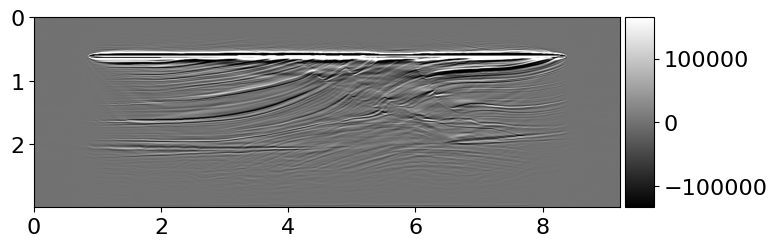

In [16]:
from examples.seismic.plot_model_mod import plot_image2
plot_image2(np.diff(image.data, axis=1),model,clip_percent=98,clip_low=2)


Original data shape: (908, 409)
Clipping low values below -133499.98438 and high values above 164674.62500.


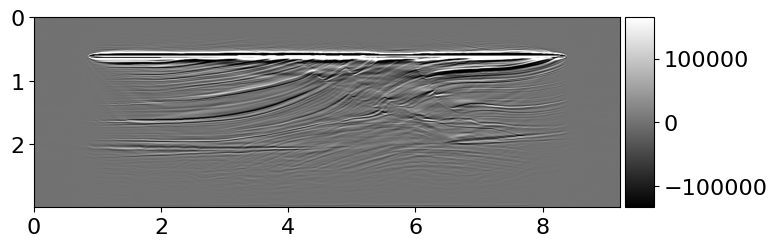

In [17]:
plot_image2(np.diff(image.data, axis=1),model,clip_percent=98,clip_low=2)


Original data shape: (738, 239)
Clipping low values below -143159.82812 and high values above 219648.79688.


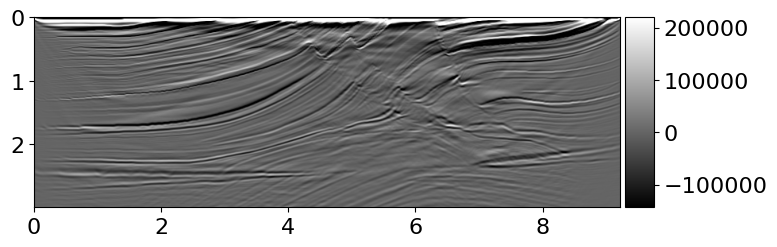

In [18]:
sliced_image = image.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(np.diff(sliced_image, axis=1),model,clip_percent=98,clip_low=2)


In [25]:
laplace_result = Function(name='lap',grid=model.grid, space_order=space_order)
stencil = Eq(laplace_result, div(grad(image)))
op = Operator([stencil])
op.apply()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000283, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Original data shape: (908, 410)
Clipping low values below -724.56506 and high values above 662.18945.


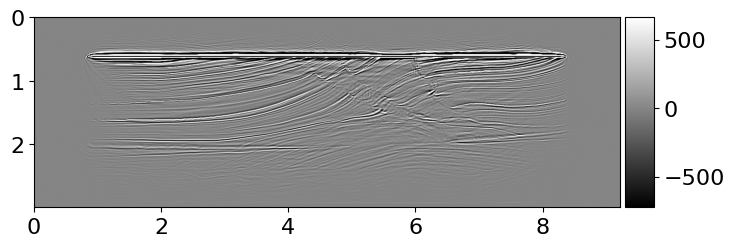

In [26]:
plot_image2(laplace_result.data,model,clip_percent=98,clip_low=2)


Original data shape: (738, 240)
Clipping low values below -799.32416 and high values above 707.54028.


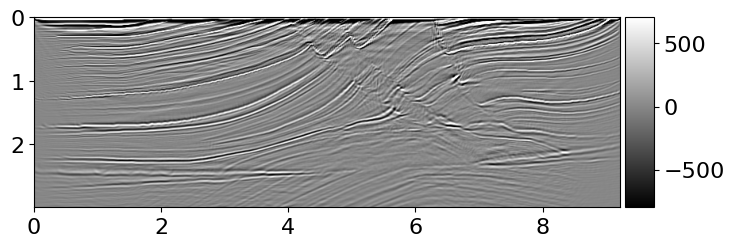

In [27]:
sliced_laplace = laplace_result.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(sliced_laplace,model,clip_percent=98,clip_low=2)
